<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Dynamic systems: 9. Shallow-water equations
## 1D solution
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Shallow-water equations in 1D

$$
\begin{array}{rcl}
\frac{\partial h}{\partial t}
+ \frac{\partial (hu)}{\partial x} = 0 \\
\frac{\partial (hu)}{\partial t}
+ \frac{\partial (hu^2 + \frac{1}{2}gh^2)}{\partial x} = 0 
\end{array}
$$
with:
- $h$ [m] - water height,
- $u$ [m/s] - velocity in $x$--direction,
- $g$ [m/s$^2$] - grav. acceleration,
- $t$ [s] - time,
- $x$ [m] - $x$-coordinates.

We develop solutions for the **shallow-water equations** for one dimension, using the
`local Lax-Friedrich and Rusanov flux` scheme (LLF-RF):
$$
\begin{array}{rcl}
F_{hu} &=& h u \\
F_{hu^2} &=& hu^2 + \frac{1}{2}gh^2
\end{array}
$$

In [9]:
nx   = 1000
xmin = 0.; xmax = 10.0
TMAX = 2.0
CFL  = 0.99
g    = 9.81
dx   = (xmax-xmin) / (nx-1)

Courant time step, patching ...

In [10]:
def dtCourant(dx,maxeigen,time,TMAX,CFL):
    dt  = CFL*dx/maxeigen
    if time+dt>TMAX:
        dt = TMAX-time
    return dt

def addGhostCells(var,gleft,gright):
    return np.hstack([gleft,var,gright])

Boundary conditions ...

In [11]:
def bcNeumann(var):
    ### NEUMANN BC ###
    var[0]  = var[1]
    var[-1] = var[-2]
    return var

def bcPeriodic(var):
    ### PERIODIC BC ###
    var[0]  = var[-2]
    var[-1] = var[1]
    return var

----
## Ritter dam break

Dam break on dry domain without friction. Also known as *Ritter's solution*.

- **Initial condition** for $h(x,t=0)$ [m] and $u(x,t=0)$ [m/s]:

$$
h(x,t=0) = \left\{ 
\begin{array}{rl}
h_l & \mbox{for } 0 \le x \le a \\
0   & \mbox{for } x \gt a
\end{array}
\right.
$$
$h_l$ [m] initial water height in dam, 
$a$ [m], initial location of dam, and
$u(x)=0$ [m/s] initial velocity.

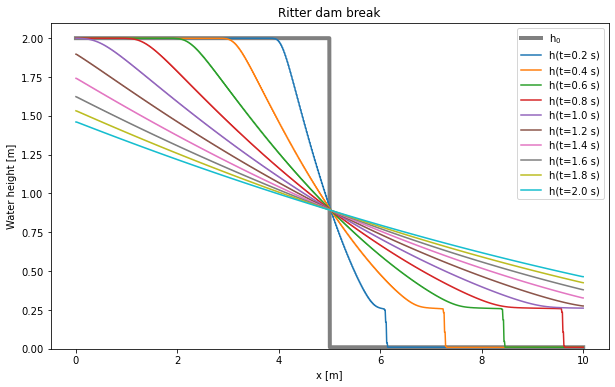

In [12]:
time   = 0.
dtplot = 0.20
tplot  = dtplot
# initialisation
x  = np.linspace(xmin,xmax,nx)
h  = np.where(x <= xmax/2, 2, .01)
hu = 0.*x
# add ghost cells
x  = addGhostCells(x,0,xmax)
h  = addGhostCells(h,0,0)
hu = addGhostCells(hu,0,0)
# initial plot
plt.figure(figsize=(10,6))
plt.ylim(0,2.1)
plt.xlabel('x [m]')
plt.ylabel('Water height [m]')
plt.title('Ritter dam break')
plt.plot(x[1:-1],h[1:-1],linewidth=4,color='gray',label='h$_0$')

while (time < TMAX):
    # set boundary conditions
    h  = bcNeumann(h)
    hu = bcNeumann(hu)
    # calculate fluxes at cell interfaces and largest eigenvalue
    c = np.sqrt(g*h)
    h = np.maximum(0.01,h)
    u = hu/h
    
    Fhup  = h[1:]*u[1:]
    Fhum  = h[:-1]*u[:-1]
    Fhu2p = h[1:]*u[1:]**2 + .5*g*(h[1:]**2)
    Fhu2m = h[:-1]*u[:-1]**2 + .5*g*(h[:-1]**2)
    
    # calculate time step according to CFL-condition
    eigen = np.max(np.maximum(np.abs(u-c),np.abs(u+c)))
    dt    = dtCourant(dx,eigen,time,TMAX,CFL)
    # advance time
    time  = time+dt
    # R = Lax-Friedrichs Flux
    Rh  = 0.5*( (Fhup+Fhum) - dx/dt*(h[1:] - h[:-1]) ) 
    Rhu = 0.5*( (Fhu2p+Fhu2m) - dx/dt*(hu[1:] - hu[:-1]) )
    # update inner points
    h[1:-1] -= dt/dx*(Rh[1:] - Rh[:-1])
    hu[1:-1] -= dt/dx*(Rhu[1:] - Rhu[:-1])
    # plot 
    if (time > tplot):
        plt.plot(x[1:-1],h[1:-1],label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

----
## Stoker's dam break

Dam break on wet domain without friction. Also known as *Stoker's solution$^2$*.

- **Initial condition** for $h(x,t=0)$ [m] and $u(x,t=0)$ [m/s]:

$$
h(x,t=0) = \left\{ 
\begin{array}{rr}
h_l & \mbox{for } 0 \le x \le a \\
h_r & \mbox{for } a \le x \le L
\end{array}
\right.
$$
and $h_l \ge h_r$, 
$a$ [m], initial location of dam, and
$u(x)=0$ [m/s] initial velocity.

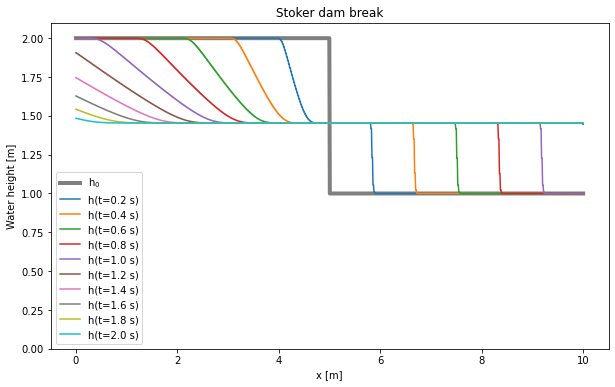

In [13]:
time   = 0.
dtplot = 0.20
tplot  = dtplot
# initialisation
x  = np.linspace(xmin,xmax,nx)
h  = np.where(x <= xmax/2, 2, 1)
hu = 0.*x
# add ghost cells
x  = addGhostCells(x,0,xmax)
h  = addGhostCells(h,0,0)
hu = addGhostCells(hu,0,0)
# initial plot
plt.figure(figsize=(10,6))
plt.ylim(0,2.1)
plt.xlabel('x [m]')
plt.ylabel('Water height [m]')
plt.title('Stoker dam break')
plt.plot(x[1:-1],h[1:-1],linewidth=4,color='gray',label='h$_0$')

while (time < TMAX):
    # set boundary conditions
    h  = bcNeumann(h)
    hu = bcNeumann(hu)
    # calculate fluxes at cell interfaces and largest eigenvalue
    c = np.sqrt(g*h)
    h = np.maximum(0.01,h)
    u = hu/h
    
    Fhup  = h[1:]*u[1:]
    Fhum  = h[:-1]*u[:-1]
    Fhu2p = h[1:]*u[1:]**2 + .5*g*(h[1:]**2)
    Fhu2m = h[:-1]*u[:-1]**2 + .5*g*(h[:-1]**2)
    
    # calculate time step according to CFL-condition
    eigen = np.max(np.maximum(np.abs(u-c),np.abs(u+c)))
    dt    = dtCourant(dx,eigen,time,TMAX,CFL)
    # advance time
    time  = time+dt
    # R = Lax-Friedrichs Flux
    Rh  = 0.5*( (Fhup+Fhum) - dx/dt*(h[1:] - h[:-1]) ) 
    Rhu = 0.5*( (Fhu2p+Fhu2m) - dx/dt*(hu[1:] - hu[:-1]) )
    # update inner points
    h[1:-1] -= dt/dx*(Rh[1:] - Rh[:-1])
    hu[1:-1] -= dt/dx*(Rhu[1:] - Rhu[:-1])
    # plot 
    if (time > tplot):
        plt.plot(x[1:-1],h[1:-1],label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

----
## Drop

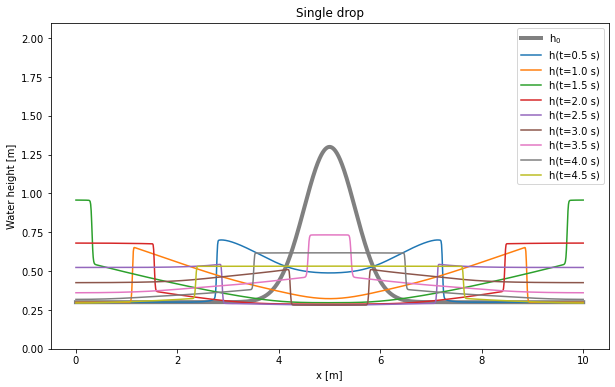

In [14]:

TMAX = 5    
time   = 0.
dtplot = 0.50
tplot  = dtplot
# initialisation
x  = np.linspace(xmin,xmax,nx)
mu = xmax/2
sigma = 0.5
h = 0.3 + np.exp(-(x-mu)**2/(2*sigma**2))
hu = 0.*x
# add ghost cells
x  = addGhostCells(x,0,xmax)
h  = addGhostCells(h,0,0)
hu = addGhostCells(hu,0,0)
# initial plot
plt.figure(figsize=(10,6))
plt.ylim(0,2.1)
plt.xlabel('x [m]')
plt.ylabel('Water height [m]')
plt.title('Single drop')
plt.plot(x[1:-1],h[1:-1],linewidth=4,color='gray',label='h$_0$')

while (time < TMAX):
    # set boundary conditions
    #h  = bcNeumann(h)
    #hu = bcNeumann(hu)
    h  = bcPeriodic(h)
    hu = bcPeriodic(hu)
    # calculate fluxes at cell interfaces and largest eigenvalue
    c = np.sqrt(g*h)
    h = np.maximum(0.01,h)
    u = hu/h
    
    Fhup  = h[1:]*u[1:]
    Fhum  = h[:-1]*u[:-1]
    Fhu2p = h[1:]*u[1:]**2 + .5*g*(h[1:]**2)
    Fhu2m = h[:-1]*u[:-1]**2 + .5*g*(h[:-1]**2)
    
    # calculate time step according to CFL-condition
    eigen = np.max(np.maximum(np.abs(u-c),np.abs(u+c)))
    dt    = dtCourant(dx,eigen,time,TMAX,CFL)
    # advance time
    time  = time+dt
    # R = Lax-Friedrichs Flux
    Rh  = 0.5*( (Fhup+Fhum) - dx/dt*(h[1:] - h[:-1]) ) 
    Rhu = 0.5*( (Fhu2p+Fhu2m) - dx/dt*(hu[1:] - hu[:-1]) )
    # update inner points
    h[1:-1] -= dt/dx*(Rh[1:] - Rh[:-1])
    hu[1:-1] -= dt/dx*(Rhu[1:] - Rhu[:-1])
    # plot 
    if (time > tplot):
        plt.plot(x[1:-1],h[1:-1],label='h(t='+str(round(time,2))+' s)')
        plt.legend()
        tplot = tplot + dtplot

... done